# Introduction to De-noising Diffusion Probabilistic Models

In [ ]:
!rm -rf diffusion
!git clone https://github.com/bd3dowling/diffusion
%cd diffusion
%pip install -e . -q

In [43]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import optax
import seaborn as sns
from IPython.display import Video

from diffusion.backwards import (
    FullyConnectedWithTime,
    fit,
)
from diffusion.forwards import (
    forward_noising,
    get_alpha_beta,
)
from diffusion.sampling import sample_with_time
from diffusion.utils import animate_heatmap, plot_heatmap, sample_sphere

rng = random.PRNGKey(2022)

sns.set_style("darkgrid")

In [9]:
train_sample = sample_sphere(12)

<Axes: >

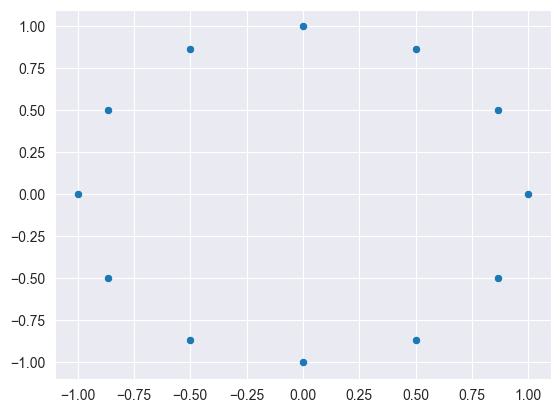

In [10]:
sns.scatterplot(x=train_sample[:, 0], y=train_sample[:, 1])

In [17]:
n = 200
alpha, beta = get_alpha_beta(n)
alpha_bar = jnp.cumprod(alpha)

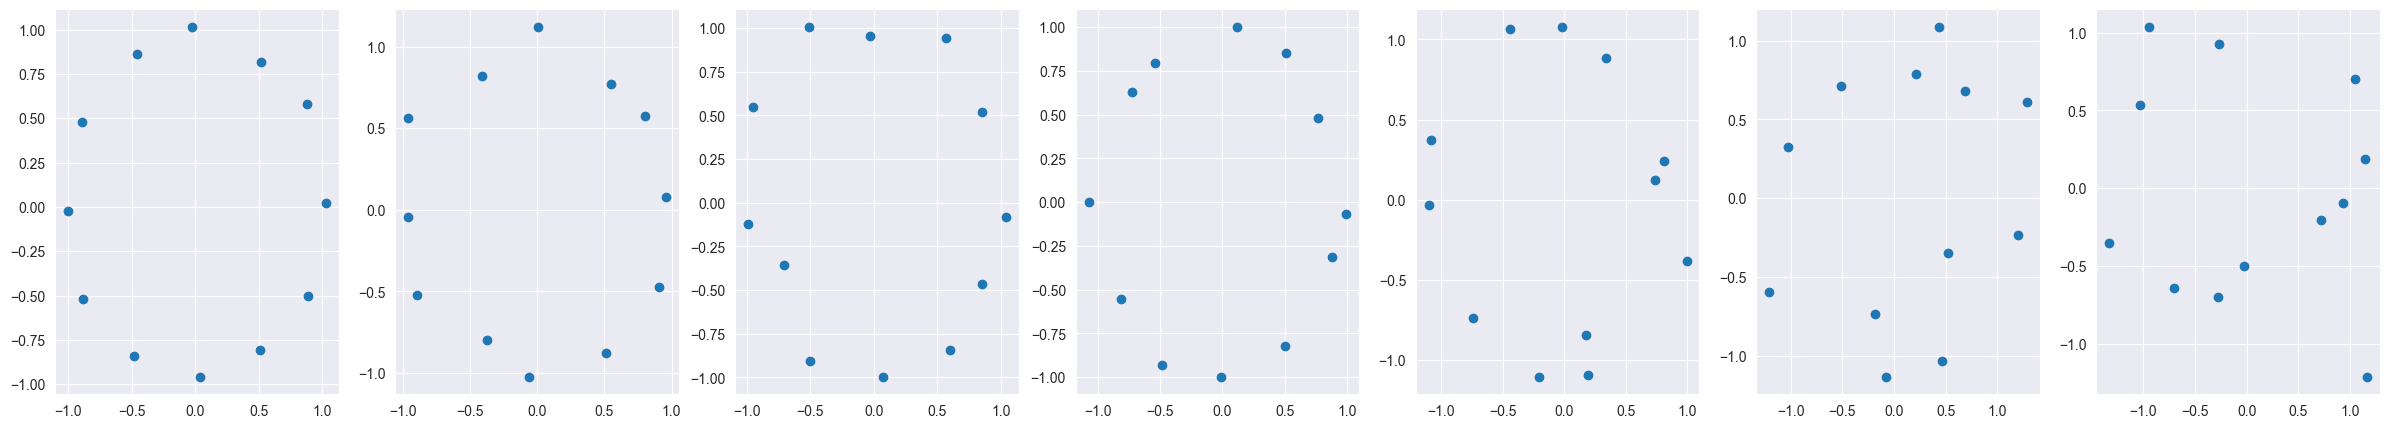

In [18]:
noisy_images, _ = forward_noising(train_sample, n, alpha)

fig = plt.figure(figsize=(30, 5))

for i, t in enumerate([1, 5, 10, 20, 50, 100, 199]):
    noisy_im = noisy_images[t]

    plt.subplot(1, 7, i + 1)
    plt.scatter(noisy_im[:, 0], noisy_im[:, 1])

plt.show()

In [19]:
n_epochs = 60_000
x = jnp.zeros(2 * 10).reshape((10, 2))
time = jnp.ones((10, 1))

# initialize the model weights
denoiser_model = FullyConnectedWithTime()
rng, srng = random.split(rng)
initial_params = denoiser_model.init(srng, x, time)

# Finally, we can fit our parametrized function using the Adam optimizer provided by optax.
optimizer = optax.adam(learning_rate=1e-3)
params = fit(n_epochs, initial_params, optimizer, rng, denoiser_model, train_sample, alpha_bar)


Epoch 5000,	 Loss 0.196694 
Epoch 10000,	 Loss 0.182533 
Epoch 15000,	 Loss 0.177203 
Epoch 20000,	 Loss 0.177352 
Epoch 25000,	 Loss 0.175769 
Epoch 30000,	 Loss 0.175276 
Epoch 35000,	 Loss 0.175410 
Epoch 40000,	 Loss 0.175883 
Epoch 45000,	 Loss 0.171634 
Epoch 50000,	 Loss 0.173992 
Epoch 55000,	 Loss 0.173501 
Epoch 60000,	 Loss 0.173346 


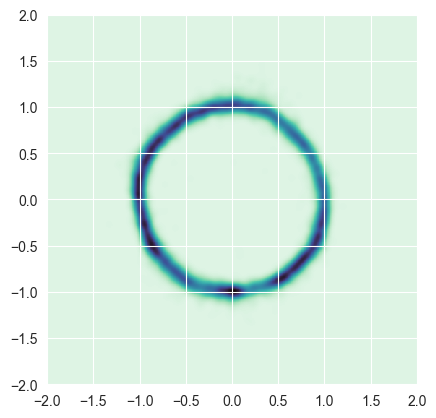

In [25]:
n_samples = 10_000
samples, all_outputs = sample_with_time(
    rng, n_samples, denoiser_model, params, alpha_bar, beta
)
im = plot_heatmap(samples)


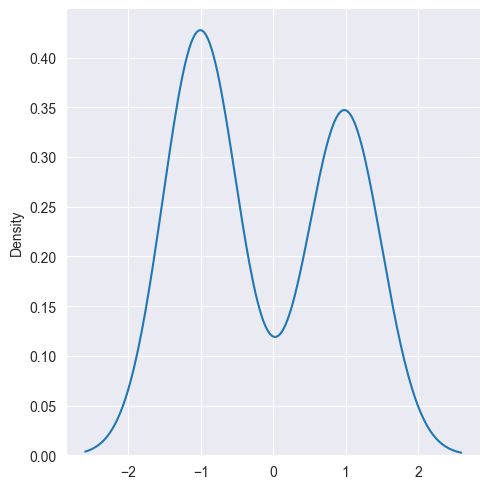

In [45]:
sns.displot(
    samples[jnp.where(round(samples[:, 1], ndigits = 2) == 0)][:, 0],
    kind='kde'
)

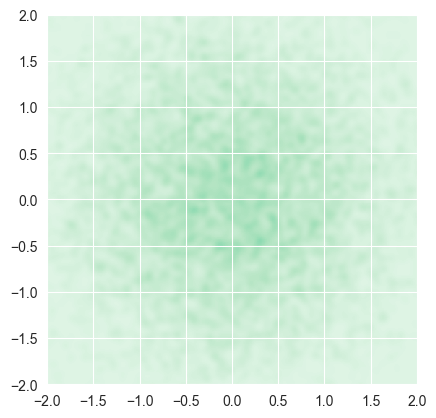

<Figure size 800x800 with 0 Axes>

In [44]:
animation = animate_heatmap(samples, all_outputs)

animation.save("samples.mp4", fps=10, extra_args=["-vcodec", "libx264"])

Video("samples.mp4")